In [1]:
# Flight fare prediction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Preprocessing
# import dataset
df = pd.read_excel("Data_Train.xlsx")

# drop null value
df.dropna(inplace=True)

# drop duplicates
df.drop_duplicates(keep='first', inplace=True)

# convert Dep_Time and Arrival_Time into hour and minute
# Dep_Time
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_minute"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df = df.drop(columns="Dep_Time")

# Arrival_Time
df["Arr_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arr_minute"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
df = df.drop(columns="Arrival_Time")

# convert Date_of_Journey into timestamp
df["Date_of_Journey_Year"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.year
# ps. I don't think "year" is mandatory
df["Date_of_Journey_Month"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.month
df["Date_of_Journey_Day"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.day
df = df.drop(columns="Date_of_Journey")


# convert Duration into minute
df['Duration'] = df['Duration']\
    .str.replace("h", '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

# Normalize Duration using Min-Max scaling
scaler = MinMaxScaler()
df['Duration'] = scaler.fit_transform(df['Duration'].values.reshape(-1, 1))

# drop Additional_Info 
df.drop(['Additional_Info'], axis=1, inplace=True)

# drop Route
df.drop(['Route'], axis=1, inplace=True) 

# Encode categorical attributes
# Select categorical data
df_categorical = df[['Airline', 'Source', 'Destination']]
df.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)


# Encode
df_categorical = pd.get_dummies(df_categorical, drop_first=True)
df['Total_Stops'] = df['Total_Stops'].map({"non-stop":0, "1 stop": 1, "2 stops": 2, "3 stops":3, "4 stops": 4})

# Concat categorical and numerical data
preprocessed = pd.concat([df, df_categorical], axis=1)
target = df['Price']

# Drop 'Price' because price is the target variable
preprocessed.drop(['Price'], axis=1, inplace=True)

# Train_Test_Split
data_train, data_test, target_train, target_test = train_test_split(
    preprocessed, target,test_size=0.3, random_state=42)

In [2]:
from sklearn.linear_model import LinearRegression

# Linear Regression
regressor = LinearRegression()
regressor.fit(data_train, target_train)

# Prediction on test data
target_pred = regressor.predict(data_test)

In [3]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(target_test, target_pred)
print('Mean Squared Error (MSE):', mse)

Mean Squared Error (MSE): 8079460.364604042


In [4]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(target_test, target_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 2842.4391575905443


In [5]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(target_test, target_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 1977.658217263782


In [6]:
from sklearn.metrics import r2_score

# Calculate R-squared score (R^2)
r2 = r2_score(target_test, target_pred)

# Print the R-squared score
print("R-squared (R^2):", r2)

R-squared (R^2): 0.6109769413220887


In [7]:
# Calculate R-squared score
r2 = r2_score(target_test, target_pred)

# Calculate the number of samples and predictors
n = len(target_test)
p = data_test.shape[1]

# Calculate adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the adjusted R-squared score
print("Adjusted R-Squared (Adjusted R^2):", adjusted_r2)

Adjusted R-Squared (Adjusted R^2): 0.607348228327023


In [8]:
# Average value of the dependent variable, if all independent variables have the value 0 or are not considered

print(regressor.intercept_)

7081.919512707193


In [9]:
# Coefficients for each feature

print(regressor.coef_)

[ 1.45383469e+02  2.82320718e+03  2.29455998e+01 -1.25570397e+00
 -6.23724115e+00  3.13590762e+00  3.33670869e-11 -4.08629765e+02
 -7.44710045e+01  1.59974579e+03 -3.09621860e+01  2.59821360e+02
  4.45090269e+03  4.65860099e+04  3.82557081e+03  3.99675238e+03
 -2.10689713e+02 -3.63797881e-12  2.10801404e+03  2.91170160e+03
  5.87485109e+01 -3.62979421e+00 -1.17246324e+02 -8.19192331e+02
 -3.62979421e+00 -8.53947954e+02 -8.19192331e+02  5.87485109e+01
  1.73526789e+03]


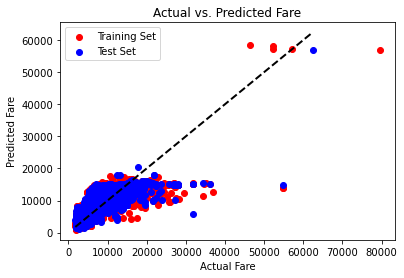

In [10]:
# Plotting the linear regression
plt.scatter(target_train, regressor.predict(data_train), color='red', label='Training Set')
plt.scatter(target_test, target_pred, color='blue', label='Test Set')
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Actual vs. Predicted Fare')
plt.legend()
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Define the Linear Regression model
linear_reg = LinearRegression()

# Define the hyperparameters to tune
parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Perform GridSearchCV with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(linear_reg, parameters, cv=cv)
grid_search.fit(data_train, target_train)

# Get the best estimator
best_linear_reg = grid_search.best_estimator_

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:")
print(grid_search.best_params_)
print("Best Score:")
print(grid_search.best_score_)


Best Hyperparameters:
{'fit_intercept': True, 'normalize': True}
Best Score:
0.6209264643453344


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Define the Linear Regression model
linear_reg = LinearRegression()

# Define the hyperparameters to tune
parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Perform GridSearchCV with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(linear_reg, parameters, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(data_train, target_train)

# Get the best estimator
best_linear_reg = grid_search.best_estimator_

# Calculate MSE on the test set
predictions = best_linear_reg.predict(data_test)
mse = mean_squared_error(target_test, predictions)

# Print the best hyperparameters, corresponding score, and MSE
print("Best Hyperparameters:")
print(grid_search.best_params_)
print("Best Score:")
print(grid_search.best_score_)
print("Mean Squared Error (MSE):")
print(mse)


Best Hyperparameters:
{'fit_intercept': False, 'normalize': True}
Best Score:
-8112999.053492693
Mean Squared Error (MSE):
8079460.36460422
